In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Example attention weights (randomly generated)
num_heads = 2
input_seq_len = 5
output_seq_len = 4

# Random attention weights for each head
attention_example = np.random.rand(num_heads, output_seq_len, input_seq_len)
print(attention_example[0])

[[0.65863797 0.67191951 0.09632743 0.73171509 0.86719185]
 [0.14223084 0.304478   0.7721001  0.04947649 0.09992013]
 [0.52789738 0.18109734 0.28301091 0.2693724  0.76023247]
 [0.91387682 0.83954926 0.65504483 0.0796263  0.393055  ]]


In [7]:
attention_weights = np.load('attention_scores.npy')
attention_weights = attention_weights[-1]

In [9]:
attention_weights

array([[[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]]])

(8, 1, 1)


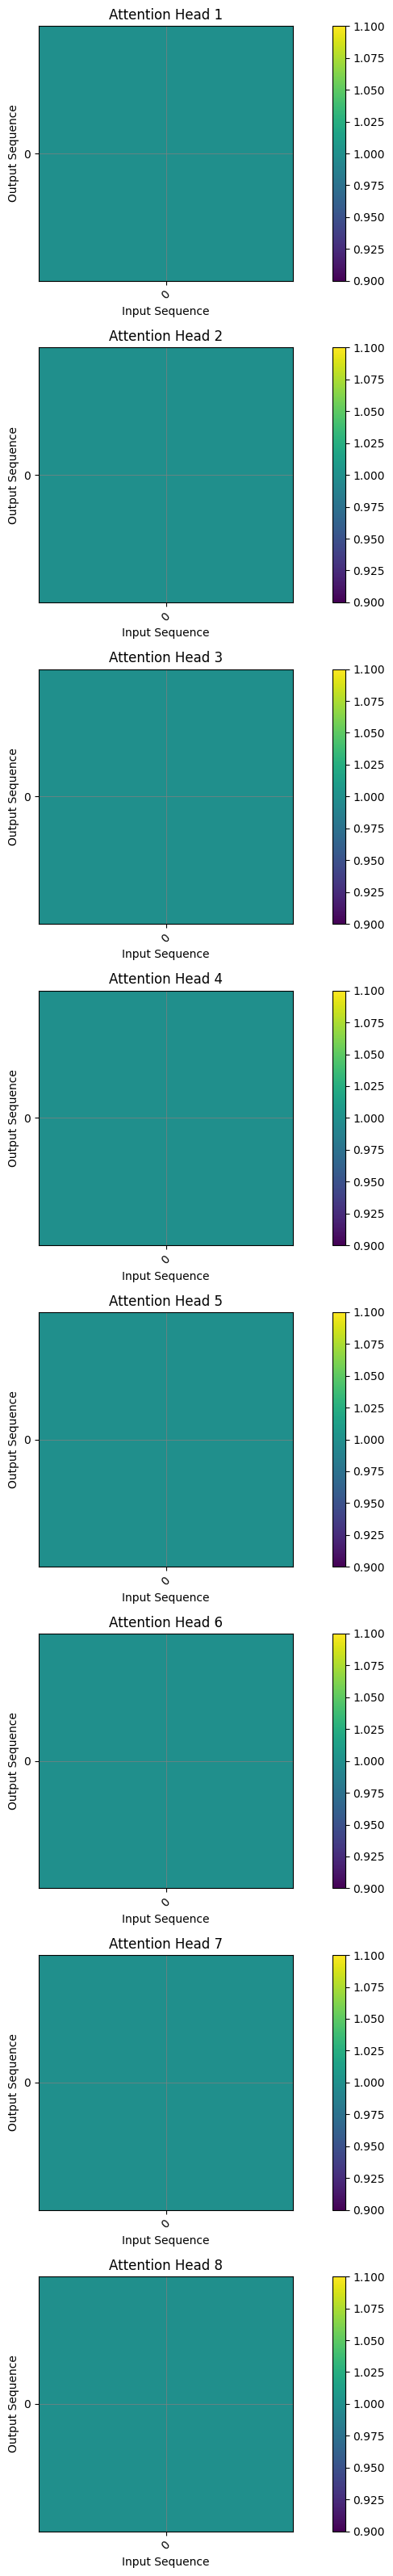

In [8]:
# Function to visualize attention weights
def visualize_attention(attention_weights):
    num_heads, output_seq_len, input_seq_len = attention_weights.shape
    print(attention_weights.shape)
    fig, axes = plt.subplots(nrows=num_heads, ncols=1, figsize=(10, 4*num_heads))
    # print(enumerate(axes))
    
    for i, ax in enumerate(axes):
        # print(i)
        ax.set_title(f'Attention Head {i+1}')
        ax.imshow(attention_weights[i], cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')
        ax.set_xticks(np.arange(input_seq_len))
        ax.set_yticks(np.arange(output_seq_len))
        ax.grid(color='gray', linestyle='-', linewidth=0.5)
        ax.xaxis.set_tick_params(rotation=45)
        ax.colorbar = ax.figure.colorbar(ax.imshow(attention_weights[i]), ax=ax)
    
    plt.tight_layout()
    plt.show()


# Visualize attention weights
visualize_attention(attention_weights)
